<a href="https://colab.research.google.com/github/HoseinNekouei/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import math
import torch
import pandas as pd
import numpy as np
from torch.optim import AdamW
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

userdata.get('HF_TOKEN')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import matplotlib.colors as mcolors

class ModelMetrics:
    @staticmethod
    def calculate_metrics(preds, labels):
        """Calculate accuracy and F1-score for a single fold."""
        pred_labels = torch.argmax(preds, dim=1)
        correct = torch.sum(pred_labels == labels).item()
        total = len(labels)
        accuracy = correct / total
        f1 = f1_score(labels.numpy(), pred_labels.numpy(), average='macro')
        return {'accuracy': accuracy, 'f1_score': f1}

    @staticmethod
    def calculate_final_metrics(all_preds, all_labels):
        """Calculate mean and standard deviation of metrics across all folds."""
        accuracy_scores = []
        f1_scores = []

        for preds, labels in zip(all_preds, all_labels):
            metrics = ModelMetrics.calculate_metrics(preds, labels)
            accuracy_scores.append(metrics['accuracy'])
            f1_scores.append(metrics['f1_score'])

        accuracy_scores = torch.tensor(accuracy_scores)
        f1_scores = torch.tensor(f1_scores)

        return {
            'mean_accuracy': torch.mean(accuracy_scores),
            'std_accuracy': torch.std(accuracy_scores),
            'mean_f1': torch.mean(f1_scores),
            'std_f1': torch.std(f1_scores)
        }

    @staticmethod
    def plot_mean_roc_curve(all_folds_preds, all_folds_labels, n_classes):
        """Plot the mean ROC curve across all folds with dynamic colors."""
        mean_fpr = np.linspace(0, 1, 100)
        tprs = [[] for _ in range(n_classes)]
        aucs = [[] for _ in range(n_classes)]
        colors = list(mcolors.TABLEAU_COLORS.values())[:n_classes]  # Dynamic color selection

        for fold_preds, fold_labels in zip(all_folds_preds, all_folds_labels):
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(fold_labels.numpy() == i, fold_preds[:, i].numpy())
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs[i].append(interp_tpr)
                aucs[i].append(auc(fpr, tpr))

        mean_tpr = [np.mean(tprs[i], axis=0) for i in range(n_classes)]
        mean_auc = [np.mean(aucs[i]) for i in range(n_classes)]
        std_auc = [np.std(aucs[i]) for i in range(n_classes)]

        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            plt.plot(mean_fpr, mean_tpr[i], color=colors[i],
                     label=f'Class {i} (Mean AUC = {mean_auc[i]:.2f} ± {std_auc[i]:.2f})')
            std_tpr = np.std(tprs[i], axis=0)
            tprs_upper = np.minimum(mean_tpr[i] + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr[i] - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=0.2)

        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Mean ROC Curve Across All Folds (±1 SD)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

In [8]:
class SentimentAnalysisModel:
    def __init__(self, checkpoint, num_labels=3, epochs=2, batch_size=32, n_splits=5, save_path=None):
        """Initialize the sentiment analysis model with configurable parameters."""
        self.checkpoint = checkpoint
        self.num_labels = num_labels  # Configurable number of classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.save_path = save_path or f"sentiment_model_{checkpoint.split('/')[-1]}.pt"
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Moved import os to top

        self.tokenizer, self.model = self.load_model_and_tokenizer()
        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)
        self.scheduler = None  # Initialized in train_model

    def load_model_and_tokenizer(self):
        """Load tokenizer and model with error handling."""
        try:
            tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
            model = AutoModelForSequenceClassification.from_pretrained(self.checkpoint, num_labels=self.num_labels)
            model.to(self.device)
            return tokenizer, model
        except Exception as e:
            raise RuntimeError(f"Failed to load model or tokenizer: {str(e)}")

    def tokenize_texts(self, texts):
        """Tokenize a list of texts."""
        if not isinstance(texts, list):
            texts = texts.tolist()
        encodings = self.tokenizer(
            texts,
            padding=True,
            max_length=256,
            truncation=True,
            return_tensors='pt'
        )
        return encodings

    def prepare_dataloaders(self, input_ids, attention_mask, labels, train_idx, validation_idx):
        """Prepare training and validation dataloaders."""
        train_dataset = TensorDataset(input_ids[train_idx], attention_mask[train_idx], labels[train_idx])
        validation_dataset = TensorDataset(input_ids[validation_idx], attention_mask[validation_idx], labels[validation_idx])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        validation_loader = DataLoader(validation_dataset, batch_size=self.batch_size)
        return train_loader, validation_loader

    def train_model(self, train_loader):
        """Train the model with gradient clipping and learning rate scheduling."""
        self.model.train()
        total_steps = len(train_loader) * self.epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        denominator = math.ceil(len(train_loader.dataset) / self.batch_size)  # Computed once

        for epoch in range(self.epochs):
            for i, batch in enumerate(train_loader):
                inputs = {k: v.to(self.device) for k, v in zip(['input_ids', 'attention_mask', 'labels'], batch)}
                self.optimizer.zero_grad()
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Gradient clipping
                self.optimizer.step()
                self.scheduler.step()

                if (i + 1) % 10 == 0:
                    print(f'[Epoch: {epoch + 1}] -> Batch: [{i + 1}/{denominator}]')
            print(f'[Epoch: {epoch + 1}] -> Batch: [{denominator}/{denominator}]')

    def evaluate_model(self, validation_loader):
        """Evaluate the model and move tensors to CPU to manage memory."""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in validation_loader:
                inputs = {k: v.to(self.device) for k, v in zip(['input_ids', 'attention_mask'], batch[:-1])}
                labels_batch = batch[-1].to(self.device)
                outputs = self.model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                all_preds.append(probs.cpu())  # Move to CPU immediately
                all_labels.append(labels_batch.cpu())

        return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

    def kfold_cross_validation(self, train_data):
        """Perform k-fold cross-validation with improved robustness."""
        texts = train_data['text']
        labels = torch.tensor(train_data['labels'].tolist()).to(self.device)

        print("Unique labels in dataset:", torch.unique(labels))
        print("Label value range:", labels.min(), labels.max())
        assert labels.min() >= 0 and labels.max() < self.num_labels, f"Labels must be between 0 and {self.num_labels - 1}"

        encodings = self.tokenize_texts(texts)
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)

        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        all_preds_by_fold = []
        all_labels_by_fold = []

        for fold, (train_idx, validation_idx) in enumerate(kfold.split(input_ids)):
            print(f"\nFold {fold + 1}/{self.n_splits}")
            train_loader, validation_loader = self.prepare_dataloaders(input_ids, attention_mask, labels, train_idx, validation_idx)
            self.train_model(train_loader)
            fold_preds, fold_labels = self.evaluate_model(validation_loader)
            all_preds_by_fold.append(fold_preds)
            all_labels_by_fold.append(fold_labels)

            metrics = ModelMetrics.calculate_metrics(fold_preds, fold_labels)
            print(f"Validation Accuracy: {metrics['accuracy']:.4f}")
            print(f"Validation F1-Score: {metrics['f1_score']:.4f}")
            print('=' * 30)

        final_metrics = ModelMetrics.calculate_final_metrics(all_preds_by_fold, all_labels_by_fold)
        print(f"\nFinal Results:")
        print(f"Mean accuracy: {final_metrics['mean_accuracy']:.4f} ± {final_metrics['std_accuracy']:.4f}")
        print(f"Mean F1-score: {final_metrics['mean_f1']:.4f} ± {final_metrics['std_f1']:.4f}")

        ModelMetrics.plot_mean_roc_curve(all_preds_by_fold, all_labels_by_fold, self.num_labels)

        try:
            torch.save(self.model.state_dict(), self.save_path)
            print(f"\nModel saved to {self.save_path}!")
        except Exception as e:
            print(f"Failed to save model: {str(e)}")



Directory sentiment_analysis already exists, skipping clone.
Data loaded successfully:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
 1   labels  100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Unique labels in dataset: tensor([0, 1, 2], device='cuda:0')
Label value range: tensor(0, device='cuda:0') tensor(2, device='cuda:0')

Fold 1/5
[Epoch: 1] -> Batch: [3/3]
[Epoch: 2] -> Batch: [3/3]
Validation Accuracy: 0.8500
Validation F1-Score: 0.8553

Fold 2/5
[Epoch: 1] -> Batch: [3/3]
[Epoch: 2] -> Batch: [3/3]
Validation Accuracy: 0.8500
Validation F1-Score: 0.7965

Fold 3/5
[Epoch: 1] -> Batch: [3/3]
[Epoch: 2] -> Batch: [3/3]
Validation Accuracy: 0.9500
Validation F1-Score: 0.9521

Fold 4/5
[Epoch: 1] -> Batch: [3/3]
[Epoch: 2] -> Batch: [3/3]
Validation Accuracy: 1.0000
Validation F1-Score: 1.0000

Fold 5/5
[Epoch: 1] -> Batch: [3/3]
[Epoch: 2] -> Batch: [3/3]
Validation Accuracy: 1.0000
Validation F1-Score: 1.0000

Final Results:
Mean accuracy: 0.9300 ± 0.0758
Mean F1-score: 0.9208 ± 0.0912


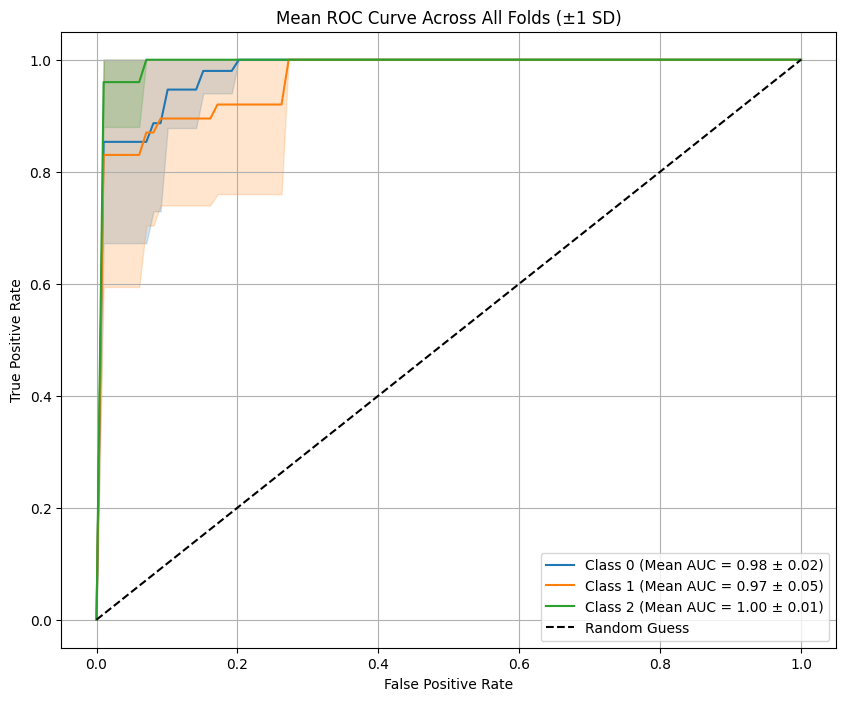


Model saved to trained_model_twitter-roberta-base-sentiment-latest.pt!


In [10]:
import os
import subprocess
import sys

def clone_repository(repo_url, target_dir):
    """Clone a Git repository to the target directory with error handling."""
    try:
        if not os.path.exists(target_dir):
            subprocess.run(['git', 'clone', repo_url, target_dir], check=True)
            print(f"Repository cloned to {target_dir}")
        else:
            print(f"Directory {target_dir} already exists, skipping clone.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {str(e)}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error during cloning: {str(e)}")
        sys.exit(1)

def load_data(file_path, nrows=None):
    """Load data from a CSV file with error handling."""
    try:
        data = pd.read_csv(file_path, nrows=nrows)
        print("Data loaded successfully:")
        print(data.info())
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        sys.exit(1)
    except pd.errors.EmptyDataError:
        print(f"Error: File at {file_path} is empty")
        sys.exit(1)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        sys.exit(1)

def get_config():
    """Return a configuration dictionary with training parameters."""
    return {
        'nrows': 100,
        'n_splits': 5,
        'epochs': 2,
        'batch_size': 32,
        'checkpoint': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
        'repo_url': 'https://github.com/HoseinNekouei/sentiment_analysis.git',
        'repo_dir': 'sentiment_analysis',
        'file_path': 'sentiment_analysis/twitter_train_corpus.csv',
        # 'alternative_file_path': '/content/drive/MyDrive/dataset/aspected_stanfordnlp_IMDB_train_corpus.csv'
    }

def main():
    """Main function to orchestrate the sentiment analysis process."""
    # Load configuration
    config = get_config()

    # Clone repository if needed
    clone_repository(config['repo_url'], config['repo_dir'])

    # Determine which file path to use
    # file_path = config['file_path'] if os.path.exists(config['file_path']) else config['alternative_file_path']
    file_path = config['file_path']
    if not os.path.exists(file_path):
        # print(f"Error: Neither {config['file_path']} nor {config['alternative_file_path']} exists.")
        print(f"Error: {config['file_path']} no exists.")
        sys.exit(1)

    # Load data
    train_data = load_data(file_path, nrows=config['nrows'])

    # Initialize and train the model
    try:
        model = SentimentAnalysisModel(
            checkpoint=config['checkpoint'],
            num_labels=3,  # Assuming 3 classes; adjust if needed
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            n_splits=config['n_splits'],
            save_path=f"trained_model_{config['checkpoint'].split('/')[-1]}.pt"
        )
        model.kfold_cross_validation(train_data)
    except Exception as e:
        print(f"Error during model training: {str(e)}")
        sys.exit(1)

if __name__ == "__main__":
    main()